In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("weatherAUS.csv")

In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
df.shape

(145460, 23)

Both "RainToday" and "RainTomorrow" are object (Yes/No). We will convert them into binary (1/0) for our convenience.

In [6]:
df['RainToday'].replace({'No':0,'Yes':1},inplace=True)
df['RainTomorrow'].replace({'No':0,'Yes':1},inplace=True)

We will check if there is any imblance dataset. If dataset is imbalanced, we need to undersample majority and oversample minority.

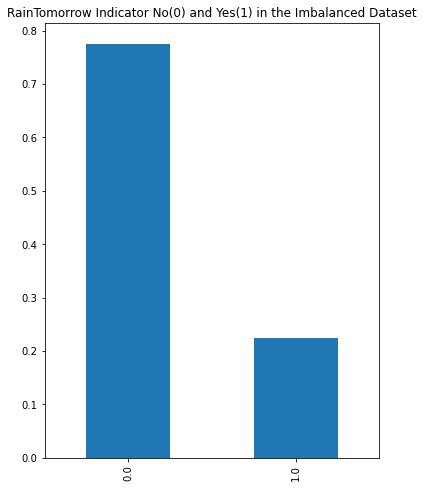

In [7]:
plt.figure(figsize=(6,8))
df['RainTomorrow'].value_counts(normalize=True).plot(kind='bar')
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

since the class is imbalance, we need to balance the data by oversampling minority class since the dataset is quite small and undersampling doesn't make any sense here.

In [8]:
from sklearn.utils import resample
no = df[df.RainTomorrow==0]
yes=df[df.RainTomorrow==1]
yes_oversampled = resample(yes,replace=True,n_samples=len(no),random_state=123)
oversampled = pd.concat([no,yes_oversampled])

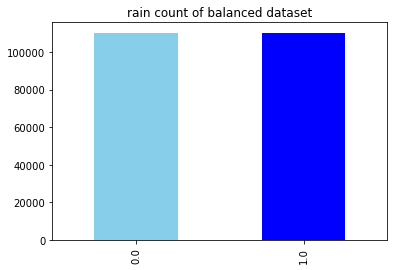

In [9]:
oversampled.RainTomorrow.value_counts().plot(kind='bar',color=['skyblue','blue'])
plt.title('rain count of balanced dataset')
plt.show()

Handling missing values

In [10]:
null_values=oversampled.isnull().sum(axis=0)
null_values

Date                  0
Location              0
MinTemp            1082
MaxTemp             471
Rainfall           3124
Evaporation       95411
Sunshine         104831
WindGustDir       15491
WindGustSpeed     15354
WindDir9am        14728
WindDir3pm         6440
WindSpeed9am       2206
WindSpeed3pm       4353
Humidity9am        3171
Humidity3pm        6031
Pressure9am       21728
Pressure3pm       21746
Cloud9am          81339
Cloud3pm          85614
Temp9am            1653
Temp3pm            4558
RainToday          3124
RainTomorrow          0
dtype: int64

<AxesSubplot:>

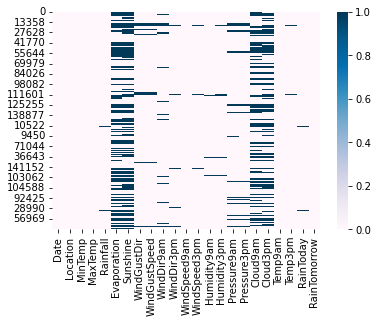

In [11]:
sns.heatmap(oversampled.isnull(),cmap='PuBu')

from the above heatmap we can say that Evaporation,Sunshine,Cloud9am,Cloud3pm are having majority missing values

In [12]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing.head()

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664
Pressure3pm,21746,0.098562


we observe that top 4 features are having >50% missing values. so, instead of discarding them we will consider then in our model with proper imputation 

# Imputation and transformation

we will impute categorical values with the help of mode and then with the help of label encoder we will convert them into numerical values. Once the full dataframe's values are converted into numerical, we will handle the missing values with the help of MICE. Then we will detect the outliers with the help of IQR and remove them to get the final working dataset. Then we will check the correlation of features and if any of the 2 features are highly correlated, we will remove one of the features.

In [13]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [14]:
oversampled['WindGustDir']=oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am']=oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm']=oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [15]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [20]:
MiceImputed.isna().sum(axis=0)

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [21]:
MiceImputed.shape

(220632, 23)

In [22]:
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3-Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [23]:
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

The dataset is free of outliers now. We will check for the multicollinearity i.e., whether the features are correlated with each other

<AxesSubplot:>

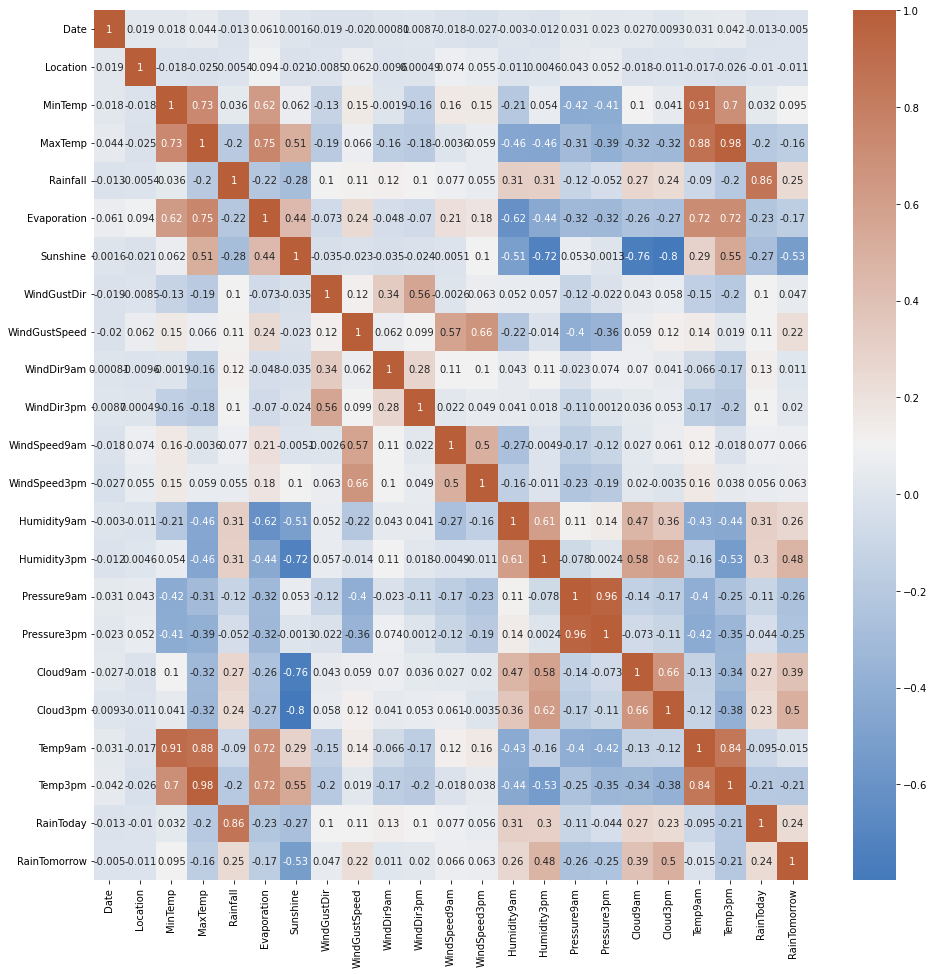

In [24]:
plt.figure(figsize=(16,16))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(MiceImputed.corr(),cmap= cmap,annot=True)

The following pairs of features are having high correlation between them:
MaxTemp and MinTemp, Pressure9am and Pressure3pm, Temp9am and Temp3pm, Evaporation and MaxTemp
MaxTemp and Temp3pm But in no case, the correlation value is equal to a perfect "1". So we are not discarding any feature.

# Feature Selection

Feature selection by filter method (Chi-Square method) : before doing feature selection we need to standardize our data. we are using MinMaxScaler instead of StandardScaler.

In [25]:
from sklearn.preprocessing import MinMaxScaler
r_scaler = MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed),index=MiceImputed.index,columns = MiceImputed.columns)
modified_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.437385,0.569756,0.512042,0.866667,0.521127,0.866667,...,0.551807,0.222773,0.245714,0.298295,0.868449,0.420458,0.506775,0.530612,0.24783,0.0
1,0.115575,0.041667,0.375350,0.568966,0.374872,0.563868,0.745836,0.933333,0.521127,0.400000,...,0.247750,0.252666,0.328571,0.318182,0.339380,0.227713,0.514905,0.594388,0.24783,0.0
2,0.115866,0.041667,0.529412,0.583744,0.374872,0.695026,0.793365,1.000000,0.549296,0.866667,...,0.180182,0.302488,0.242857,0.343750,0.347461,0.173437,0.617886,0.566327,0.24783,0.0
3,0.116157,0.041667,0.425770,0.640394,0.374872,0.584743,0.762539,0.266667,0.239437,0.600000,...,0.259012,0.162986,0.528571,0.460227,0.297350,0.183513,0.539295,0.650510,0.24783,0.0
4,0.116448,0.041667,0.658263,0.746305,0.479060,0.638825,0.413485,0.866667,0.478873,0.066667,...,0.675683,0.332382,0.334286,0.267045,0.784042,0.693747,0.531165,0.732143,0.24783,0.0


In [26]:
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.drop('RainTomorrow', axis=1)
y = modified_data['RainTomorrow']
selector = SelectKBest(chi2, k=10)
selector.fit(X,y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
X = modified_data.drop('RainTomorrow', axis=1)
y = modified_data['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100,random_state=0))
selector.fit(X,y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100,random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03251436 0.02889938 0.03316543 0.03250381 0.02138441 0.03312043
 0.13821858 0.02075391 0.04266396 0.02135522 0.02173827 0.02171846
 0.02339726 0.03437621 0.10775466 0.04842712 0.06112705 0.05757376
 0.13952883 0.03151427 0.03611667 0.01214795]


As explained by the dataset creator Joe Young, "RISKMM is the amount of rainfall in millimeters for the next day. It includes all forms of precipitation that reach the ground, such as rain, drizzle, hail and snow. And it was the column that was used to actually determine whether or not it rained to create the binary target. Since it contains information directly about the target variable, including it would leak the future information to our model" (Quoted from his comment). So "RISK_MM" is excluded from the model. "Date" is also excluded from the model for the obvious reason since it is not adding any relevance in the current context.

In [28]:
features = modified_data[['Location','MinTemp' ,'MaxTemp','Rainfall','Evaporation',
                         'Sunshine','WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm',
                         'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am','Humidity9am','Humidity3pm',
                         'Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm','RainToday']]
target = modified_data['RainTomorrow']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.25,random_state=123)

## Normalize Features

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

In [29]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0,1],[0,1],color='blue',linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

In [31]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score,plot_confusion_matrix, roc_curve, classification_report

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose = 0)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test,y_pred)
    time_taken = time.time()-t0
    print('Accuracy = {}'.format(accuracy))
    print('ROC area under curve = {}'.format(roc_auc))
    print("Cohen's kappa = {}".format(cohen_kappa))
    print('Time Taken = {}'.format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_curve(fper,tper)
    plot_confusion_matrix(model, X_test,y_test,cmap=plt.cm.Blues,normalize='all')
    return model, accuracy, roc_auc,cohen_kappa, time_taken

Accuracy = 0.7946704790475297
ROC area under curve = 0.7885215334971366
Cohen's kappa = 0.5803443732086091
Time Taken = 3.77791166305542
              precision    recall  f1-score   support

         0.0    0.80555   0.83738   0.82116     24019
         1.0    0.77932   0.73966   0.75898     18649

    accuracy                        0.79467     42668
   macro avg    0.79244   0.78852   0.79007     42668
weighted avg    0.79409   0.79467   0.79398     42668



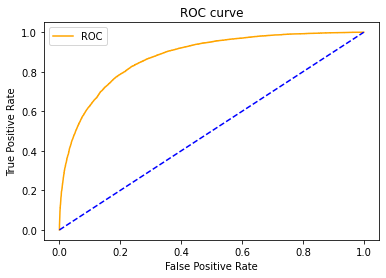

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


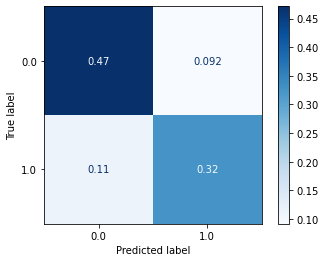

In [32]:
from sklearn.linear_model import LogisticRegression
params = {'penalty':'l1','solver':'liblinear'}
model_lr = LogisticRegression(**params)
model_lr,accuracy_lr,roc_auc_lr,cohen_lr,tt_lr = run_model(model_lr, X_train,y_train,X_test,y_test)

Accuracy = 0.8703712383988
ROC area under curve = 0.8718125330521544
Cohen's kappa = 0.7384153864477985
Time Taken = 1.0401108264923096
              precision    recall  f1-score   support

         0.0    0.90469   0.86036   0.88197     24019
         1.0    0.83083   0.88326   0.85624     18649

    accuracy                        0.87037     42668
   macro avg    0.86776   0.87181   0.86911     42668
weighted avg    0.87241   0.87037   0.87073     42668



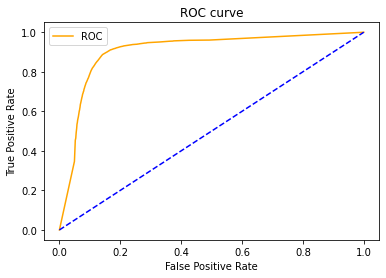

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


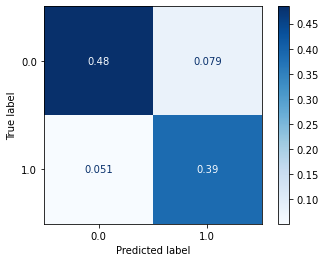

In [35]:
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth':16,'max_features':'sqrt'}
model_dt = DecisionTreeClassifier(**params_dt)
model_dt,accuracy_dt,roc_auc_dt,cohen_dt,tt_dt = run_model(model_dt,X_train,y_train,X_test,y_test)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8879253773319584
ROC area under curve = 0.8863973245875149
Cohen's kappa = 0.772368711242617
Time Taken = 427.7600727081299
              precision    recall  f1-score   support

         0.0    0.90199   0.89854   0.90026     24019
         1.0    0.86996   0.87426   0.87210     18649

    accuracy                        0.88793     42668
   macro avg    0.88598   0.88640   0.88618     42668
weighted avg    0.88799   0.88793   0.88796     42668



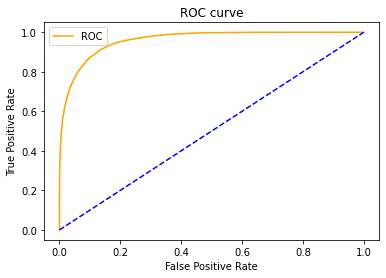

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


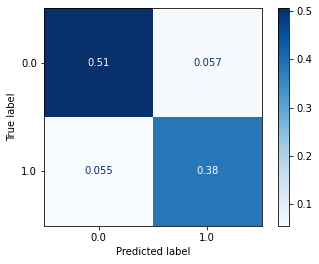

In [36]:
from sklearn.neural_network import MLPClassifier
param_nn = {'hidden_layer_sizes':(30,30,30),'activation':'logistic','solver':'lbfgs','max_iter':500}
model_nn = MLPClassifier(**param_nn)
model_nn,accuracy_nn, roc_auc_nn,cohen_nn,tt_nn = run_model(model_nn,X_train,y_train,X_test,y_test)

Accuracy = 0.9268069747820381
ROC area under curve = 0.9282394576222613
Cohen's kappa = 0.8520304817099031
Time Taken = 61.85880899429321
              precision    recall  f1-score   support

         0.0    0.95136   0.91686   0.93379     24019
         1.0    0.89769   0.93962   0.91818     18649

    accuracy                        0.92681     42668
   macro avg    0.92453   0.92824   0.92598     42668
weighted avg    0.92790   0.92681   0.92697     42668



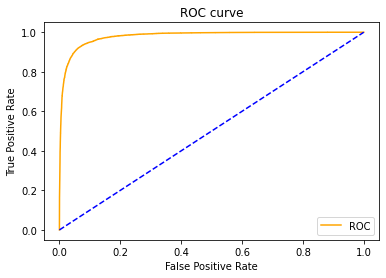

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


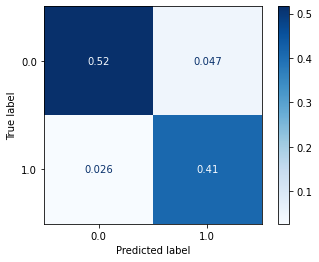

In [37]:
from sklearn.ensemble import RandomForestClassifier
params_rf = {'max_depth':16, 'min_samples_leaf':1,'min_samples_split':2,'n_estimators':100,'random_state':12345}
model_rf = RandomForestClassifier(**params_rf)
model_rf,accuracy_rf,roc_auc_rf,cohen_rf,tt_rf = run_model(model_rf,X_train,y_train,X_test,y_test)

[LightGBM] [Info] Number of positive: 56370, number of negative: 71631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 128001, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.440387 -> initscore=-0.239591
[LightGBM] [Info] Start training from score -0.239591
Accuracy = 0.8700665604199869
ROC area under curve = 0.8675377644832898
Cohen's kappa = 0.7357193999930121
Time Taken = 8.545675039291382
              precision    recall  f1-score   support

         0.0    0.88227   0.88763   0.88494     24019
         1.0    0.85413   0.84744   0.85078     18649

    accuracy                        0.87007     42668
   macro avg    0.86820   0.86754   0.86786     42668
weighted avg    0.86997   0.87007   0.87001     42668



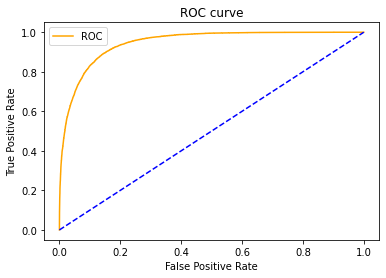

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


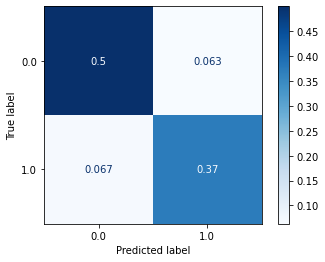

In [44]:
import lightgbm as lgb
params_lgb = {'colsample_bytree':0.95,'max_depth':16,'min_split_gain':0.1,'n_estimators':200,'num_leaves':50,
              'reg_alpha':1.2,'reg_lambda':1.2,'subsample':0.95,'subsample_freq':20}
model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb,accuracy_lgb,roc_auc_lgb,cohen_lgb,tt_lgb = run_model(model_lgb,X_train,y_train,X_test,y_test)

In [48]:
    pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install lightgbm 

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 1.3/1.3 MB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Learning rate set to 0.5
0:	learn: 0.4472116	total: 15.6s	remaining: 12m 44s
1:	learn: 0.3574969	total: 31s	remaining: 12m 24s
2:	learn: 0.3141450	total: 47.4s	remaining: 12m 23s
3:	learn: 0.2722785	total: 1m 4s	remaining: 12m 16s
4:	learn: 0.2531531	total: 1m 19s	remaining: 11m 53s
5:	learn: 0.2268741	total: 1m 34s	remaining: 11m 34s
6:	learn: 0.2144528	total: 1m 50s	remaining: 11m 19s
7:	learn: 0.1976329	total: 2m 6s	remaining: 11m 1s
8:	learn: 0.1841044	total: 2m 23s	remaining: 10m 51s
9:	learn: 0.1698949	total: 2m 40s	remaining: 10m 42s
10:	learn: 0.1601591	total: 2m 56s	remaining: 10m 24s
11:	learn: 0.1465690	total: 3m 11s	remaining: 10m 6s
12:	learn: 0.1306025	total: 3m 26s	remaining: 9m 48s
13:	learn: 0.1222357	total: 3m 42s	remaining: 9m 31s
14:	learn: 0.1142074	total: 3m 57s	remaining: 9m 14s
15:	learn: 0.1064090	total: 4m 12s	remaining: 8m 56s
16:	learn: 0.0999262	total: 4m 28s	remaining: 8m 40s
17:	learn: 0.0936589	total: 4m 43s	remaining: 8m 24s
18:	learn: 0.0889488	total: 

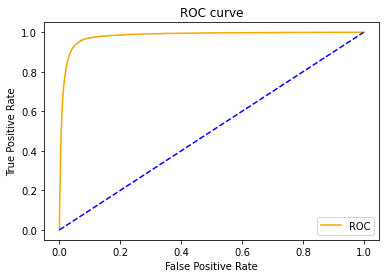

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


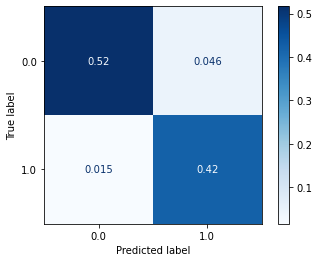

In [50]:
import catboost as cb
params_cb = {'iterations':50,'max_depth':16}
model_cb = cb.CatBoostClassifier(**params_cb)
model_cb,accuracy_cb,roc_auc_cb,cohen_cb,tt_cb = run_model(model_cb,X_train,y_train,X_test,y_test)

In [49]:
!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/0c/cd/a05bbb220e9b45b4cadcb22d5e801aeece7b301f5775d78e13972d0f60cf/catboost-1.2.2-cp39-cp39-win_amd64.whl.metadata
  Using cached catboost-1.2.2-cp39-cp39-win_amd64.whl.metadata (1.2 kB)
   ---------------------------------------- 101.0/101.0 MB 6.0 MB/s eta 0:00:00


[23:37:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "penalty", "solver" } are not used.

Accuracy = 0.8700196868847848
ROC area under curve = 0.8674361884192209
Cohen's kappa = 0.7355955074311371
Time Taken = 26.536278247833252
              precision    recall  f1-score   support

         0.0    0.88194   0.88796   0.88494     24019
         1.0    0.85442   0.84691   0.85065     18649

    accuracy                        0.87002     42668
   macro avg    0.86818   0.86744   0.86780     42668
weighted avg    0.86991   0.87002   0.86995     42668



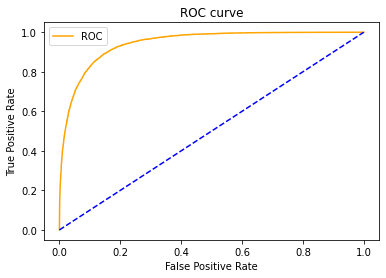

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


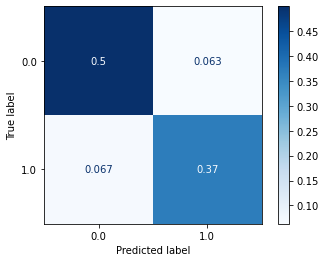

In [51]:
import xgboost as xgb
params_xgb = {'n_estimators':500,'mx_depth':16}
model_xgb = xgb.XGBClassifier(**params)
model_xgb,accuracy_xgb,roc_auc_xgb,cohen_xgb,tt_xgb = run_model(model_xgb,X_train,y_train,X_test,y_test)

# Plotting Decision Tree for all models

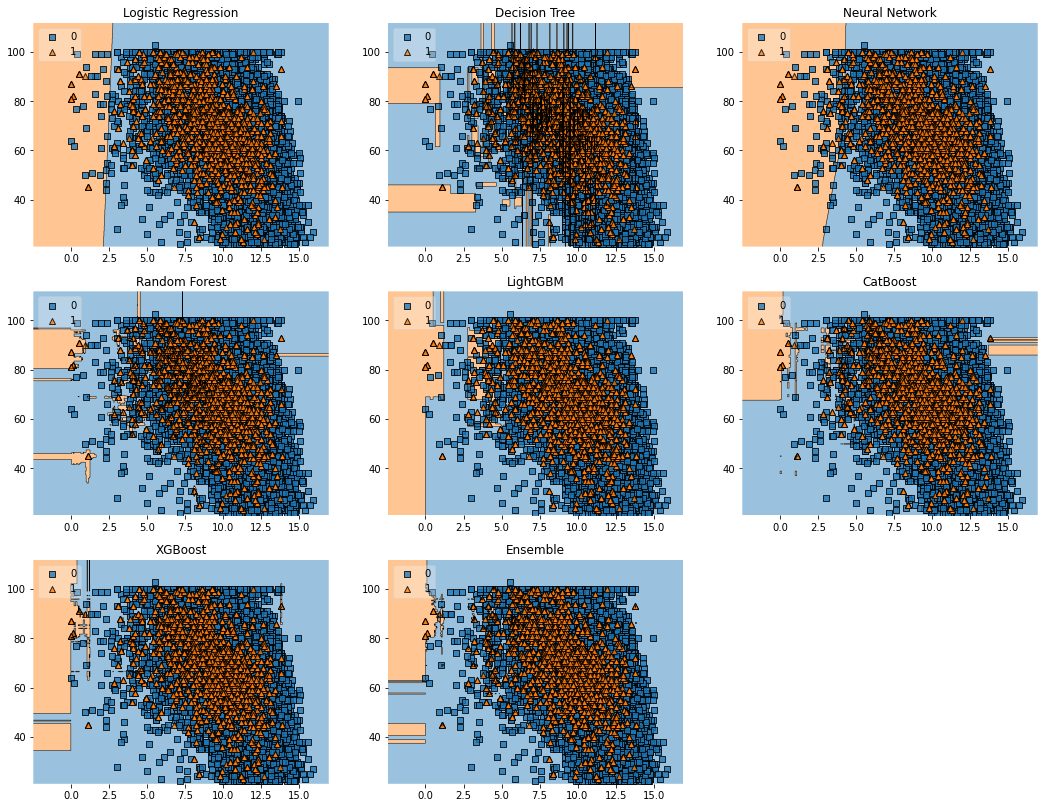

In [61]:
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345)
clf3 = MLPClassifier(random_state=12345,verbose=0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345,verbose=0)
clf6 = cb.CatBoostClassifier(random_state=12345,verbose=0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4,clf5,clf6,clf7],weights=[1,1,1,1],voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]]
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)
                      

In [54]:
!pip install mlxtend

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/73/da/d5d77a9a7a135c948dbf8d3b873655b105a152d69e590150c83d23c3d070/mlxtend-0.23.0-py3-none-any.whl.metadata
   ---------------------------------------- 1.4/1.4 MB 8.4 MB/s eta 0:00:00


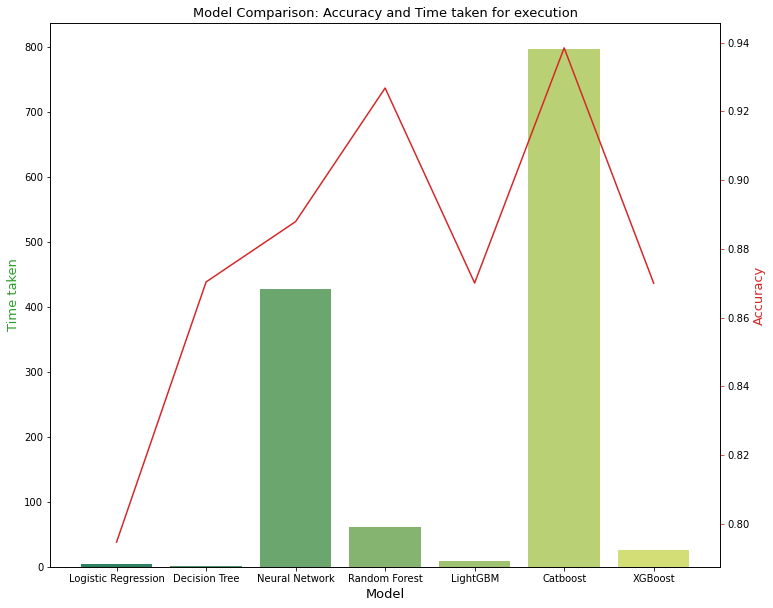

In [63]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [cohen_lr, cohen_dt, cohen_nn, cohen_rf, cohen_lgb, cohen_cb, cohen_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)
fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

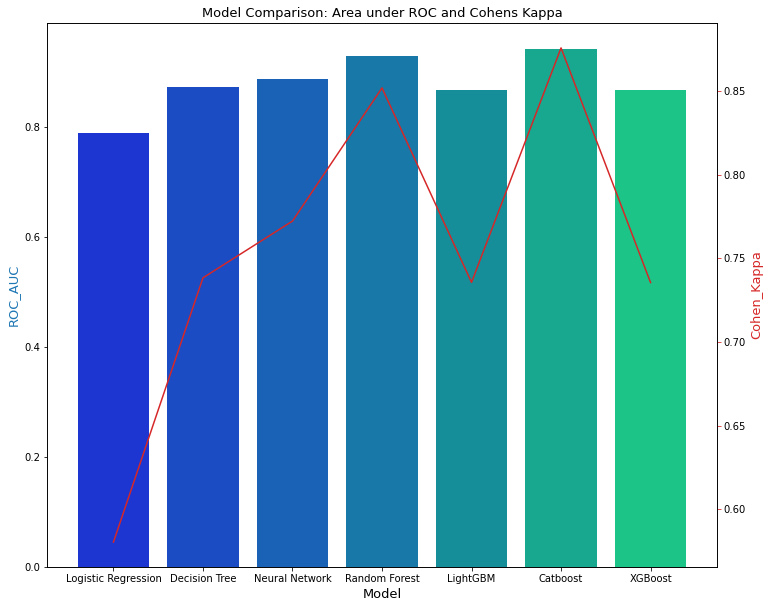

In [64]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

We can observe that XGBoost, CatBoost and Random Forest have performed better compared to other models. However, if speed is an important thing to consider, we can stick to Random Forest instead of XGBoost or CatBoost.